# Predicting Game Outcome Using Team & Player Stats

NBA Seasons 2019-2022

In [35]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## 1. Data Cleaning & Processing

In [36]:
# read data source
df_full = pd.read_csv('nba_stats.csv',index_col=False)

C:\Users\theri\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
df_full.shape

(115715, 83)

In [38]:
# remove unwanted columns: 'PG%', 'SG%','SF%', 'PF%', 'C%'
df_full = df_full.drop(columns=['PG%', 'SG%','SF%', 'PF%', 'C%'],axis=1)

In [39]:
df_full.drop_duplicates(inplace=True)

In [40]:
df_full.shape

(91706, 78)

In [41]:
#convert game date to datetime field
df_full['game_date'] = pd.to_datetime(df_full['game_date'])

In [42]:
# Function to count the number of inactive player names in a comma delimited string
count_names = lambda text: len(str(text).split(',')) if pd.notna(text) else 0

# Apply the function to the 'Inactives' column (replaces list of names with count of names)
df_full['Inactives'] = df_full['Inactives'].apply(count_names)

In [43]:
#extract minutes from 'mp' (minutes played) field and convert to integer
get_minutes = lambda text: int(str(text).split(':')[0]) if pd.notna(text) else 0

df_full['mp'] = df_full['mp'].apply(get_minutes)

In [44]:
#convert sports betting rates to floats
dkp_cvt = lambda num: float(num) if pd.notna(num) and num != "#NAME?" else 0
fdp_cvt = lambda num: float(num) if pd.notna(num) and num != "#NAME?" else 0
sdp_cvt = lambda num: float(num) if pd.notna(num) and num != "#NAME?" else 0

df_full['DKP_per_minute'] = df_full['DKP_per_minute'].apply(dkp_cvt)
df_full['FDP_per_minute'] = df_full['FDP_per_minute'].apply(fdp_cvt)
df_full['SDP_per_minute'] = df_full['SDP_per_minute'].apply(sdp_cvt)

In [45]:
#drop 'duplicate' field
df_full.drop(columns = ['duplicate'],inplace=True)

In [46]:
#get list of columns that contain NaN values
columns_with_nan = df_full.columns[df_full.isna().any()].tolist()

print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['pf_per_minute', 'last_60_minutes_per_game_starting', 'last_60_minutes_per_game_bench', 'active_position_minutes']


In [47]:
#drop rows with nan values
df_full_cleaned = df_full.copy()

In [48]:
df_full_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91706 entries, 0 to 115714
Data columns (total 77 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   game_id                            91706 non-null  object        
 1   game_date                          91706 non-null  datetime64[ns]
 2   OT                                 91706 non-null  int64         
 3   H_A                                91706 non-null  object        
 4   Team_Abbrev                        91706 non-null  object        
 5   Team_Score                         91706 non-null  int64         
 6   Team_pace                          91706 non-null  float64       
 7   Team_efg_pct                       91706 non-null  float64       
 8   Team_tov_pct                       91706 non-null  float64       
 9   Team_orb_pct                       91706 non-null  float64       
 10  Team_ft_rate                     

In [49]:
df_full_cleaned.shape

(91706, 77)

In [50]:
#Get sum and mean player stats

'''
df_player_sums = df_full_cleaned.groupby(by = ['season','player','Team_Abbrev'],as_index=False).agg (sumfg = ('fg','sum'),sumfg3=('fg3','sum'),sumft=('ft','sum'),sumorb=('orb','sum'),sumast=('ast','sum'),sumpts=('pts','sum'),sumdrb = ('drb','sum'),sumstl=('stl','sum'),sumblk=('blk','sum'))
df_player_avg = df_full_cleaned.groupby(by = ['season','player','Team_Abbrev'],as_index=False).agg (avgfg = ('fg','mean'),avgfg3=('fg3','mean'),avgft=('ft','mean'),avgorb=('orb','mean'),avgast=('ast','mean'),avgpts=('pts','mean'),avgdrb = ('drb','mean'),avgstl=('stl','mean'),avgblk=('blk','mean'))

df_player_avg = df_player_avg.iloc[:,3:]

df_player_sum_avg = pd.concat([df_player_sums, df_player_avg],axis=1)

df_player_sum_avg.head()
'''

"\ndf_player_sums = df_full_cleaned.groupby(by = ['season','player','Team_Abbrev'],as_index=False).agg (sumfg = ('fg','sum'),sumfg3=('fg3','sum'),sumft=('ft','sum'),sumorb=('orb','sum'),sumast=('ast','sum'),sumpts=('pts','sum'),sumdrb = ('drb','sum'),sumstl=('stl','sum'),sumblk=('blk','sum'))\ndf_player_avg = df_full_cleaned.groupby(by = ['season','player','Team_Abbrev'],as_index=False).agg (avgfg = ('fg','mean'),avgfg3=('fg3','mean'),avgft=('ft','mean'),avgorb=('orb','mean'),avgast=('ast','mean'),avgpts=('pts','mean'),avgdrb = ('drb','mean'),avgstl=('stl','mean'),avgblk=('blk','mean'))\n\ndf_player_avg = df_player_avg.iloc[:,3:]\n\ndf_player_sum_avg = pd.concat([df_player_sums, df_player_avg],axis=1)\n\ndf_player_sum_avg.head()\n"

In [51]:
#df_player_sum_avg.head()

In [52]:
#df_player_sum_avg.to_excel('nba_player_stats.xlsx',index=False)

In [53]:
#Define the pure defensive and offensive player stats (By pure I mean those stats that can only be regarded as defensive or offensive)--excluding percentages as a fg percentage of 100% is misleading if the player only attempted one fg.
player_def_stats_cols = ['game_id','Team_Abbrev','Opponent_Abbrev','outcome','stl','blk','drb']

player_off_stats_cols = ['game_id','Team_Abbrev','Opponent_Abbrev','outcome','fg','fg3','ft','orb','ast','pts']

In [54]:
#create player def stats dataframe
df_player_def = df_full_cleaned[player_def_stats_cols]

#create player off stats dataframe
df_player_off = df_full_cleaned[player_off_stats_cols]

#create df with combined (def+off) player stats
df_player_combined = df_full_cleaned[player_def_stats_cols + player_off_stats_cols]
df_player_combined = df_player_combined.iloc[:,4:]

In [55]:
df_player_def.shape, df_player_off.shape, df_player_combined.shape

((91706, 7), (91706, 10), (91706, 13))

In [56]:
#aggregate stats by team
df_def_agg = df_player_def.groupby(by=['game_id','Team_Abbrev','Opponent_Abbrev','outcome'],as_index=False).agg (sumdrb = ('drb','sum'),sumstl=('stl','sum'),sumblk=('blk','sum'))
df_off_agg = df_player_off.groupby(by=['game_id','Team_Abbrev','Opponent_Abbrev','outcome'],as_index=False).agg (sumfg = ('fg','sum'),sumfg3=('fg3','sum'),sumft=('ft','sum'),sumorb=('orb','sum'),sumast=('ast','sum'),sumpts=('pts','sum'))
df_combined_agg = df_player_combined.groupby(by=['game_id','Team_Abbrev','Opponent_Abbrev','outcome'],as_index=False).agg (sumfg = ('fg','sum'),sumfg3=('fg3','sum'),sumft=('ft','sum'),sumorb=('orb','sum'),sumast=('ast','sum'),sumpts=('pts','sum'),sumdrb = ('drb','sum'),sumstl=('stl','sum'),sumblk=('blk','sum'))

In [57]:
#create offensive score feature

# 1. create new column that combines Opponent's Abbrev and the game id
df_combined_agg['opponent_id'] = df_combined_agg.apply(lambda row: row['Opponent_Abbrev'] + '_' + str(row['game_id']),axis = 1)



'''
# 2. create dictionary that maps 'opponent_id' values to teams offensive stats
offense_lead_dict = {}
offense_lead_dict = dict(zip(df_combined_agg['opponent_id'],zip(df_combined_agg['sumfg'],
                                                                df_combined_agg['sumfg3'],df_combined_agg['sumft'],
                                                                df_combined_agg['sumorb'],
                                                                df_combined_agg['sumast'],df_combined_agg['sumpts'])))
'''

# 2. create dictionary that maps 'opponent_id' values to teams offensive stats (removed sumpts)
offense_lead_dict = {}
offense_lead_dict = dict(zip(df_combined_agg['opponent_id'],zip(df_combined_agg['sumfg'],df_combined_agg['sumfg3'],df_combined_agg['sumft'],
                                                               df_combined_agg['sumorb'],df_combined_agg['sumast'])))


# 3. compare team and opponent defensive stats, if two or more team def stats are greater than opponent's def stats then 'good D' otherwise 'bad D'

final_score = [] #stores sum of def_score for each team
for i in range(0,df_combined_agg.shape[0]):
    
    off_score = [] #empty list to store 1s if current teams defensive stat exceeds opponent's
    
    '''
    team_off_tup = (df_combined_agg['sumfg'][i],df_combined_agg['sumfg3'][i],df_combined_agg['sumft'][i],
                   df_combined_agg['sumorb'][i],df_combined_agg['sumast'][i],df_combined_agg['sumpts'][i]) # current team's defensive stats
    
    '''
    team_off_tup = (df_combined_agg['sumfg'][i],df_combined_agg['sumfg3'][i],df_combined_agg['sumft'][i],
                   df_combined_agg['sumorb'][i],df_combined_agg['sumast'][i]) # current team's defensive stats
    
    tupKey_off = df_combined_agg['Team_Abbrev'][i] + '_' + df_combined_agg['game_id'][i] #dictionary key to get opponents defensive stats
    opp_tup = offense_lead_dict[tupKey_off] #opponents defensive stats
    
    #logic to calculate team's defensive score
    if team_off_tup[0] > opp_tup[0]:
        off_score.append(1)
    else:
        off_score.append(0)
    if team_off_tup[1] > opp_tup[1]:
        off_score.append(1)
    else:
        off_score.append(0)
    if team_off_tup[2] > opp_tup[2]:
        off_score.append(1)
    else:
        off_score.append(0)
    if team_off_tup[3] > opp_tup[3]:
        off_score.append(1)
    else:
        off_score.append(0)
    if team_off_tup[4] > opp_tup[4]:
        off_score.append(1)
    else:
        off_score.append(0)
    
    '''
    if team_off_tup[5] > opp_tup[5]:
        off_score.append(1)
    else:
        off_score.append(0)
    '''
        
    #final_score.append(1 if sum(off_score) >= 4 else 0) #sum values in def_score and append to final_score
    final_score.append(1 if sum(off_score) >= 3 else 0) #sum values in def_score and append to final_score

    
df_combined_agg['Offensive Effort'] = final_score

In [58]:
#create defensive score feature

# 1. create new column that combines Opponent's Abbrev and the game id
df_combined_agg['opponent_id'] = df_combined_agg.apply(lambda row: row['Opponent_Abbrev'] + '_' + str(row['game_id']),axis = 1)

# 2. create dictionary that maps 'opponent_id' values to teams defensive stats
defense_lead_dict = {}
defense_lead_dict = dict(zip(df_combined_agg['opponent_id'],zip(df_combined_agg['sumdrb'],df_combined_agg['sumstl'],df_combined_agg['sumblk'])))

# 3. compare team and opponent defensive stats, if two or more team def stats are greater than opponent's def stats then 'good D' otherwise 'bad D'

final_score = [] #stores sum of def_score for each team
for i in range(0,df_combined_agg.shape[0]):
    
    def_score = [] #empty list to store 1s if current teams defensive stat exceeds opponent's
    team_tup = (df_combined_agg['sumdrb'][i],df_combined_agg['sumstl'][i],df_combined_agg['sumblk'][i]) # current team's defensive stats
    
    tupKey = df_combined_agg['Team_Abbrev'][i] + '_' + df_combined_agg['game_id'][i] #dictionary key to get opponents defensive stats
    opp_tup = defense_lead_dict[tupKey] #opponents defensive stats
    
    #logic to calculate team's defensive score
    if team_tup[0] > opp_tup[0]:
        def_score.append(1)
    else:
        def_score.append(0)
    if team_tup[1] > opp_tup[1]:
        def_score.append(1)
    else:
        def_score.append(0)
    if team_tup[2] > opp_tup[2]:
        def_score.append(1)
    else:
        def_score.append(0)
        
    final_score.append(1 if sum(def_score) >= 2 else 0) #sum values in def_score and append to final_score
    
df_combined_agg['Defensive Effort'] = final_score

In [59]:
df_combined_agg.columns, df_def_agg.columns, df_off_agg.columns

(Index(['game_id', 'Team_Abbrev', 'Opponent_Abbrev', 'outcome', 'sumfg',
        'sumfg3', 'sumft', 'sumorb', 'sumast', 'sumpts', 'sumdrb', 'sumstl',
        'sumblk', 'opponent_id', 'Offensive Effort', 'Defensive Effort'],
       dtype='object'),
 Index(['game_id', 'Team_Abbrev', 'Opponent_Abbrev', 'outcome', 'sumdrb',
        'sumstl', 'sumblk'],
       dtype='object'),
 Index(['game_id', 'Team_Abbrev', 'Opponent_Abbrev', 'outcome', 'sumfg',
        'sumfg3', 'sumft', 'sumorb', 'sumast', 'sumpts'],
       dtype='object'))

In [60]:
#get subset of data that only contains fields with numerical values

cols_to_exclude = ['game_id','Team_Abbrev','Opponent_Abbrev']

df_def_num = df_def_agg.drop(columns=cols_to_exclude)
df_off_num = df_off_agg.drop(columns=cols_to_exclude)
df_combined_num = df_combined_agg.drop(columns=cols_to_exclude)
df_combined_num = df_combined_num.drop(columns='opponent_id')

In [61]:
#df_combined_num.to_csv('nba_data.csv',index=False)

In [62]:
df_combined_num.head()

,outcome,sumfg,sumfg3,sumft,sumorb,sumast,sumpts,sumdrb,sumstl,sumblk,Offensive Effort,Defensive Effort
0,1,42,11,17,11,24,112,34,8,5,1,1
1,0,37,13,15,9,20,102,32,4,7,0,0
2,0,43,19,17,16,30,122,37,4,9,1,0
3,1,42,14,32,16,23,130,41,7,3,0,1
4,0,48,15,15,10,19,126,38,8,9,0,0


## 2. Data Exploration

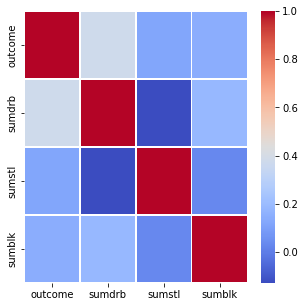

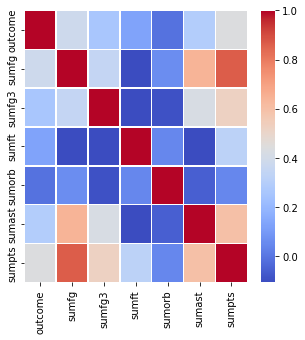

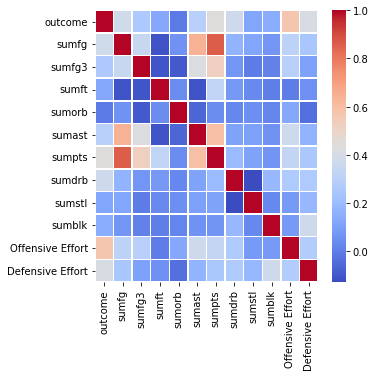

In [63]:
#get subset of numerated columns in preparation for correlation matrix

# Normalize quantitative fields using Min-Max scaling
scaler = MinMaxScaler()
df_def_scaled = pd.DataFrame(scaler.fit_transform(df_def_num), columns=df_def_num.columns)
df_off_scaled = pd.DataFrame(scaler.fit_transform(df_off_num), columns=df_off_num.columns)
df_combined_scaled = pd.DataFrame(scaler.fit_transform(df_combined_num), columns=df_combined_num.columns)



scaled_df_lst = [df_def_scaled,df_off_scaled,df_combined_scaled]

for df in scaled_df_lst:
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    plt.figure(figsize=(5,5))

    # Create a heatmap using seaborn
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)



    # Show the plot
    plt.show()

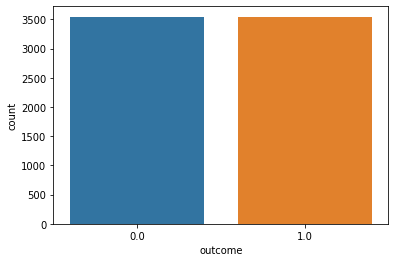

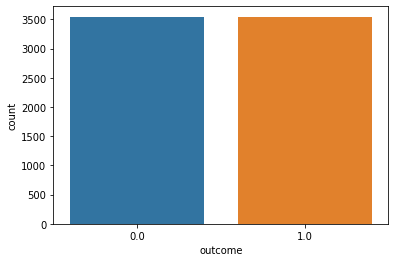

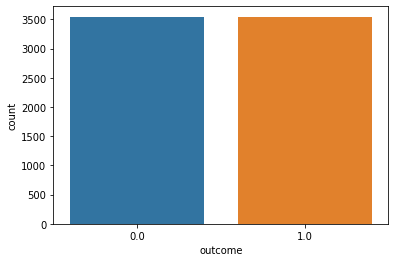

In [64]:
#distribution of wins and losses
for df in scaled_df_lst:

    sns.countplot(x='outcome', data=df)

    plt.show()

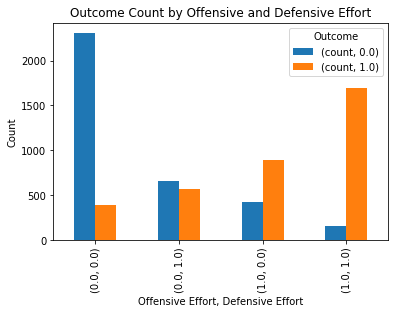

In [65]:
#visualize the effect of defense and offense on game outcome

# Group by 'offense' and 'defense', then count the occurrences of each outcome
grouped_df = df_combined_scaled.groupby(['Offensive Effort', 'Defensive Effort', 'outcome']).size().reset_index(name='count')

# Pivot the dataframe to make 'outcome' values as columns
pivot_df = grouped_df.pivot_table(index=['Offensive Effort', 'Defensive Effort'], columns='outcome', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=False)
plt.title('Outcome Count by Offensive and Defensive Effort')
plt.xlabel('Offensive Effort, Defensive Effort')
plt.ylabel('Count')
plt.legend(title='Outcome')
plt.show()

## 3. Define & Train Model

In [66]:
#import ML libraries
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm as svm_linear
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split as tts


In [67]:
def misclassification_cost(arg1, arg2):
    
    # function for calculating the missclassification cost of a classifier given test labels and predicted labels returned from the
    # trained classifier.
    
    '''
    inputs:
    arg1 = array of test labels
    arg2 = array of predicted labels
    
    returns:
    misclassification cost
    '''

    #print confusion matrix
    CM = confusion_matrix(arg1,arg2)
    print(CM)

    #define cost matrix shape
    cM = np.zeros(CM.shape)

    #assign weights to cost matrix
    if cM.shape == (3,3):
        cM[0] = [0,1,2]
        cM[1] = [1,0,1]
        cM[2] = [2,1,0]

    # for binary classification
    elif cM.shape ==(2,2):
        cM[0] = [0,1]
        cM[1] = [1,0]

    elif cM.shape == (5,5):
        cM[0] = [0,1,2,3,4]
        cM[1] = [1,0,1,2,3]
        cM[2] = [2,1,0,1,2]
        cM[3] = [3,2,1,0,1]
        cM[4] = [4,3,2,1,0]

    #calculate classification cost
    cM_matrix = np.matrix(CM * cM)
    clcost = cM_matrix.sum()/arg2.shape[0]
    
    return(clcost)

In [68]:
def classifier(arg1,arg2,arg3):
    
    '''
    arg1: X Features
    arg2: y Label
    arg3: random seed
    '''


    modelDict = {'DecisionTreeClassifier':'max_depth = %d,random_state = %d' % (4,0),
                 'RandomForestClassifier':'',
                 'svm.SVC':'kernel="rbf"', 
                 'KNeighborsClassifier':'n_neighbors = 4',
                 'svm_linear.SVC':'kernel="linear"'
                }

    model_lst = list(modelDict.keys())  


    #create lists for storing model scores for cross-validation
    models = []
    accuracy = []
    mpca = []
    f1_wt = []

    #create lists for storing model scores
    accuracy2 = []
    mpca2 = []
    f1_wt2 = []
    cost2 = []
    unique2 = []



    for key in modelDict.keys():
        print(key)
        models.append(key)

        #define classifier with parameters including penalizing parameters
        clf = eval('%s(%s)' % (key,modelDict[key]))


        #evaluate pipeline

        # define cross-validation method for model evaluation
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)       


        #calculate cross-validated mean per class accuracy (recall macroaverage from classification report)
        results = cross_validate(clf,arg1, arg2, scoring=['recall_macro','accuracy','f1_macro','f1_weighted'], cv=cv, n_jobs=-1,error_score='raise')

        #append cross-validation results to respective lists
        accuracy.append(results['test_accuracy'].mean())
        mpca.append(results['test_recall_macro'].mean())
        f1_wt.append(results['test_f1_weighted'].mean())





        #train each model with training data and predict on test data

        #split data into train and test data (75/25 split)
        X_train, X_test, y_train, y_test = tts(arg1, arg2, random_state=arg3)


        print(np.unique(y_train))
        #train models
        model = clf.fit(X_train, y_train)  


        #predict on test data
        y_hat = model.predict(X_test)      
        print(classification_report(y_test, y_hat))

        #print confusion matrix
        CM = confusion_matrix(y_test,y_hat)
        print(CM)


        #capture classification accuracy metrics
        report_dict = classification_report(y_test,y_hat,output_dict=True)

        #mean per class accuracy
        mpca2.append(report_dict['macro avg']['recall']) #mean per class accuracy

        #return f1 score
        f1_wt2.append(report_dict['weighted avg']['f1-score'])

        #accuracy
        accuracy2.append(report_dict['accuracy'])   

        #misclassification cost
        cost2.append(misclassification_cost(y_test,y_hat))

        #unique label predictions
        unique2.append(np.unique(y_hat))



    #create and populate dataframe with cross-validation results
    df_scores = pd.DataFrame()
    df_scores['Model'] = models
    df_scores['CV Accuracy'] = accuracy
    df_scores['CV MPCA'] = mpca
    df_scores['CV F1_weighted'] = f1_wt
    
    
    df_scores2 = pd.DataFrame()
    df_scores2['Model'] = models
    df_scores2['Accuracy'] = accuracy2
    df_scores2['MPCA'] = mpca2
    df_scores2['F1_weighted'] = f1_wt2
    df_scores2['Misclassification_Cost'] = cost2
    df_scores2['unique predictions'] = unique2




    return(df_scores,df_scores2,model)

In [69]:
#Define features and labels for all datasets
X_def = df_def_scaled.drop(columns= ['outcome'],axis=1) #predictors
y_def = df_def_scaled['outcome']

X_off = df_off_scaled.drop(columns= ['outcome'],axis=1) #predictors
y_off = df_off_scaled['outcome']

X_com = df_combined_scaled.drop(columns= ['outcome'],axis=1) #predictors
y_com = df_combined_scaled['outcome']

X_com_defeffort = df_combined_scaled.drop(columns= ['outcome','sumfg','sumfg3',
                                              'sumft','sumorb','sumast','sumstl','sumblk','sumpts',
                                              'Offensive Effort'],axis=1) #predictors
X_com_offeffort = df_combined_scaled.drop(columns= ['outcome','sumfg','sumfg3',
                                              'sumft','sumdrb','sumast','sumstl','sumblk','sumpts',
                                              'Defensive Effort'],axis=1) #predictors

In [71]:
comval,commdl,mdl = classifier(X_com_offeffort,y_com,42)

DecisionTreeClassifier
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.80       907
         1.0       0.82      0.73      0.77       865

    accuracy                           0.79      1772
   macro avg       0.79      0.79      0.79      1772
weighted avg       0.79      0.79      0.79      1772

[[765 142]
 [234 631]]
[[765 142]
 [234 631]]
RandomForestClassifier
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       907
         1.0       0.82      0.73      0.77       865

    accuracy                           0.79      1772
   macro avg       0.79      0.79      0.79      1772
weighted avg       0.79      0.79      0.79      1772

[[765 142]
 [236 629]]
[[765 142]
 [236 629]]
svm.SVC
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.80       907
         1.0       0.82      0.73      0.77       865

    accuracy

In [72]:
comval

,Model,CV Accuracy,CV MPCA,CV F1_weighted
0,DecisionTreeClassifier,0.783153,0.783158,0.782461
1,RandomForestClassifier,0.783059,0.783064,0.782365
2,svm.SVC,0.783153,0.783158,0.782461
3,KNeighborsClassifier,0.737026,0.737036,0.734566
4,svm_linear.SVC,0.783153,0.783158,0.782461


In [73]:
commdl

,Model,Accuracy,MPCA,F1_weighted,Misclassification_Cost,unique predictions
0,DecisionTreeClassifier,0.787810,0.786460,0.786973,0.212190,"[0.0, 1.0]"
1,RandomForestClassifier,0.786682,0.785304,0.785808,0.213318,"[0.0, 1.0]"
2,svm.SVC,0.787810,0.786460,0.786973,0.212190,"[0.0, 1.0]"
3,KNeighborsClassifier,0.698646,0.695639,0.693369,0.301354,"[0.0, 1.0]"
4,svm_linear.SVC,0.787810,0.786460,0.786973,0.212190,"[0.0, 1.0]"


In [75]:
defval,defmdl,mdl = classifier(X_def,y_def,42)

DecisionTreeClassifier
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.67      0.75      0.71       907
         1.0       0.70      0.61      0.65       865

    accuracy                           0.68      1772
   macro avg       0.68      0.68      0.68      1772
weighted avg       0.68      0.68      0.68      1772

[[684 223]
 [340 525]]
[[684 223]
 [340 525]]
RandomForestClassifier
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64       907
         1.0       0.63      0.64      0.63       865

    accuracy                           0.64      1772
   macro avg       0.64      0.64      0.64      1772
weighted avg       0.64      0.64      0.64      1772

[[580 327]
 [315 550]]
[[580 327]
 [315 550]]
svm.SVC
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70       907
         1.0       0.69      0.66      0.67       865

    accuracy

In [76]:
offval,offmdl,mdl = classifier(X_off,y_off,42)

DecisionTreeClassifier
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.71      0.73      0.72       907
         1.0       0.71      0.69      0.70       865

    accuracy                           0.71      1772
   macro avg       0.71      0.71      0.71      1772
weighted avg       0.71      0.71      0.71      1772

[[659 248]
 [271 594]]
[[659 248]
 [271 594]]
RandomForestClassifier
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69       907
         1.0       0.68      0.68      0.68       865

    accuracy                           0.69      1772
   macro avg       0.69      0.69      0.69      1772
weighted avg       0.69      0.69      0.69      1772

[[626 281]
 [275 590]]
[[626 281]
 [275 590]]
svm.SVC
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.73      0.71      0.72       907
         1.0       0.70      0.72      0.71       865

    accuracy

In [77]:
defval

,Model,CV Accuracy,CV MPCA,CV F1_weighted
0,DecisionTreeClassifier,0.671464,0.671451,0.670958
1,RandomForestClassifier,0.632571,0.632574,0.632449
2,svm.SVC,0.685573,0.685568,0.685281
3,KNeighborsClassifier,0.628058,0.628057,0.620961
4,svm_linear.SVC,0.687454,0.687451,0.687279


In [78]:
defmdl

,Model,Accuracy,MPCA,F1_weighted,Misclassification_Cost,unique predictions
0,DecisionTreeClassifier,0.682280,0.680535,0.680382,0.317720,"[0.0, 1.0]"
1,RandomForestClassifier,0.637698,0.637654,0.637739,0.362302,"[0.0, 1.0]"
2,svm.SVC,0.687359,0.686648,0.687032,0.312641,"[0.0, 1.0]"
3,KNeighborsClassifier,0.630926,0.627372,0.622106,0.369074,"[0.0, 1.0]"
4,svm_linear.SVC,0.689616,0.688933,0.689315,0.310384,"[0.0, 1.0]"


In [79]:
offval

,Model,CV Accuracy,CV MPCA,CV F1_weighted
0,DecisionTreeClassifier,0.706170,0.706174,0.705685
1,RandomForestClassifier,0.683500,0.683498,0.683387
2,svm.SVC,0.708990,0.708990,0.708902
3,KNeighborsClassifier,0.636049,0.636048,0.630606
4,svm_linear.SVC,0.711907,0.711911,0.711833


In [80]:
offmdl

,Model,Accuracy,MPCA,F1_weighted,Misclassification_Cost,unique predictions
0,DecisionTreeClassifier,0.707111,0.706638,0.706971,0.292889,"[0.0, 1.0]"
1,RandomForestClassifier,0.686230,0.686134,0.686252,0.313770,"[0.0, 1.0]"
2,svm.SVC,0.717269,0.717418,0.717308,0.282731,"[0.0, 1.0]"
3,KNeighborsClassifier,0.641084,0.638232,0.635550,0.358916,"[0.0, 1.0]"
4,svm_linear.SVC,0.712754,0.712445,0.712701,0.287246,"[0.0, 1.0]"


In [81]:
# train and save the best performing model (althought the combined model was the best, I will use the offensive stats model since it requires fewer inputs to make a prediction and this will make for a more user-friendly UI)
best_model = svm.SVC(kernel="rbf",probability=True).fit(X_off, y_off) 

In [84]:
X_off.head()

,sumfg,sumfg3,sumft,sumorb,sumast,sumpts
0,0.216495,0.243243,0.215385,0.34375,0.250000,0.161826
1,0.164948,0.297297,0.184615,0.28125,0.187500,0.120332
2,0.226804,0.459459,0.215385,0.50000,0.343750,0.203320
3,0.216495,0.324324,0.446154,0.50000,0.234375,0.236515
4,0.278351,0.351351,0.184615,0.31250,0.171875,0.219917


In [85]:
prediction = best_model.predict_proba(np.array(X_off.iloc[2,:]).reshape(-1,6))

In [89]:
best_model.classes_

array([0., 1.])

In [93]:
np.round(prediction[0][1]*100)

80.0

# Save Model

In [83]:
import joblib

joblib.dump(best_model,'offensive_stats_model.pkl')

['offensive_stats_model.pkl']

# Supplemental Code

In [141]:
'''
for df in scaled_df_lst:
    

    #define predictor and response variables
    X = df.drop(columns= ['outcome'],axis=1) #predictors
    y = df['outcome']              #response

    # convert class label column to int type
    y = y.astype(np.int_)

    from sklearn.model_selection import train_test_split as tts

    X_train, X_test, y_train, y_test = tts(X,y,random_state=3) 

    from collections import Counter

    train_count = Counter(y_train)
    test_count = Counter(y_test)

    print(train_count)
    print(test_count)


    #define model
    svc = SVC(kernel='rbf')

    model = svc.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy on test set: {accuracy}")

    from sklearn.metrics import classification_report

    #Precision, recall, f1-score and support
    print(classification_report(y_test, y_pred))
'''

Counter({0: 2692, 1: 2624})
Counter({1: 920, 0: 852})
Accuracy on test set: 0.6360045146726863
              precision    recall  f1-score   support

           0       0.65      0.54      0.59       852
           1       0.63      0.73      0.67       920

    accuracy                           0.64      1772
   macro avg       0.64      0.63      0.63      1772
weighted avg       0.64      0.64      0.63      1772

Counter({0: 2692, 1: 2624})
Counter({1: 920, 0: 852})
Accuracy on test set: 0.6783295711060948
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       852
           1       0.68      0.73      0.70       920

    accuracy                           0.68      1772
   macro avg       0.68      0.68      0.68      1772
weighted avg       0.68      0.68      0.68      1772

Counter({0: 2692, 1: 2624})
Counter({1: 920, 0: 852})
Accuracy on test set: 0.79627539503386
              precision    recall  f1-score   support

        

In [33]:
'''
#Find what error value is in the 'DKP_per_minute' field
for i in range(0,df_full.shape[0]):
    try:
        float(df_full['DKP_per_minute'][i])      
    except ValueError as e:
        print(df_full['DKP_per_minute'][i])
        print(df_full.iloc[i])
        print(e)
        
'''

#NAME?
game_id                                     201912260SAC
game_date                            2019-12-26 00:00:00
OT                                                     2
H_A                                                    H
Team_Abbrev                                          SAC
Team_Score                                           104
Team_pace                                           92.7
Team_efg_pct                                       0.388
Team_tov_pct                                         9.2
Team_orb_pct                                        23.9
Team_ft_rate                                       0.196
Team_off_rtg                                        92.8
Opponent_Abbrev                                      MIN
Opponent_Score                                       105
Opponent_pace                                       92.7
Opponent_efg_pct                                   0.394
Opponent_tov_pct                                    10.0
Opponent_orb_pct        